# Implementing VAR in PyMC3

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import pymc3 as pm
import theano.tensor as tt

In [3]:
import matplotlib.pyplot as plt
import arviz as az

In [4]:
import pymc3.distributions.transforms as tr

In [5]:
from regime_switching.generate.ar import VARXGenerator

In [6]:
from regime_switching.fit.ar import VAR

In [7]:
from pathlib import Path
import regime_switching

root_path = Path(regime_switching.__root__).parent

img_path = root_path / "latex" / "img" / "gen"

# Generate VAR

In [8]:
T = 100
n_endog = 2
n_lag_endog = 1

# n_exog = 0

In [9]:
vg = VARXGenerator.get_random_instance(endog=n_endog, lag_endog=n_lag_endog, random_state=11)
vg

VARXGenerator with params:
  <xarray.Dataset>
  Dimensions:              (endog: 2, exog: 0, lag_endog: 1, lag_exog: 0, pre_vals: 1, target: 2)
  Coordinates:
    * lag_exog             (lag_exog) int64 
    * lag_endog            (lag_endog) int64 1
    * endog                (endog) int64 0 1
    * target               (target) int64 0 1
    * exog                 (exog) int64 
    * pre_vals             (pre_vals) int64 -1
  Data variables:
      coef_ar              (target, endog, lag_endog) float64 -0.3071 ... -0.457
      coef_exog            (target, exog, lag_exog) float64 
      coef_covariance      (target, endog) float64 0.8736 -0.1628 -0.1628 0.2488
      coef_const           (target) float64 1.845 0.8657
      coef_initial_values  (pre_vals, target) float64 2.134 0.8573

In [10]:
data = vg.generate(T)
data

<xarray.Dataset>
Dimensions:  (target: 2, time: 100)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * target   (target) int64 0 1
Data variables:
    output   (time, target) float64 1.519 1.944 0.6698 ... 2.904 3.327 0.3324

## Test in model

### Build model

In [11]:
import warnings

warnings.simplefilter('ignore', FutureWarning)

In [12]:
with pm.Model() as m:
    cov_sd_dist = pm.HalfCauchy.dist(beta=2.5)
    cov_eta = 2
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=cov_eta, n=n_endog, sd_dist=cov_sd_dist)
    # chol = pm.expand_packed_triangular(n_endog, packed_chol, lower=True)
    # cov = pm.Deterministic('t_cov', tt.dot(chol, chol.T))
    
    pm.Normal('coef_const', 0, 10, shape=(n_endog,))
    pm.Normal('coef_initial_values', 0, 10, shape=(n_lag_endog, n_endog))

    # Note: maybe try Beta? Truncated Cauchy/Normal?
    pm.Uniform('coef_ar', -1, 1, shape=(n_endog, n_endog, n_lag_endog))
    
    obs = pm.Data('obs', data['output'].values)
    
    var = VAR(
        'var_process', 
        n_endog=n_endog, 
        n_lag_endog=n_lag_endog, 
        t_const=m['coef_const'], 
        t_init=m['coef_initial_values'],
        t_ar=m['coef_ar'],
        packed_chol=packed_chol, 
        observed=m['obs'],
    )
    cov = pm.Deterministic('coef_covariance', var.distribution.cov)

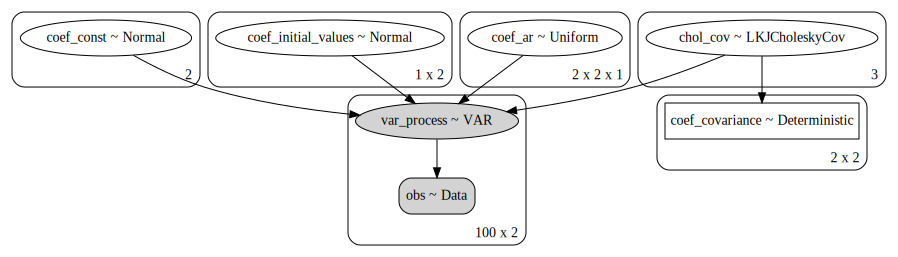

In [13]:
model_graph = pm.model_to_graphviz(m)

model_graph.render(img_path / "pp_var_graph", format="png", cleanup=True);

display(model_graph)

### Fit

In [14]:
with m:
    trace = pm.sample(draws=1000, tune=2000, chains=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [coef_ar, coef_initial_values, coef_const, chol_cov]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [04:51<00:00, 20.60draws/s]


### Posterior predictive

In [15]:
with m:
    ppc = pm.sample_posterior_predictive(trace, samples=100, random_seed=41)

/opt/conda/envs/rs-model/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


### Get InferenceData

In [16]:
with m:
    ifd = az.from_pymc3(
        trace=trace, 
        posterior_predictive=ppc,
        log_likelihood=False,  # broken
        dims={
            'coef_ar': ['target', 'endog', 'lag_endog'],
            'coef_covariance': ['target', 'endog'],
            'coef_const': ['target'],
            'coef_initial_values': ['pre_vals', 'target'],
            'obs': ['time', 'target'],
            'var_process': ['time', 'target'],
        },
        coords={
            'time': np.arange(T), 
            'target': np.arange(n_endog), 
            'endog': np.arange(n_endog),
            'lag_endog': np.arange(1, n_lag_endog + 1),
            'pre_vals': -np.arange(1, n_lag_endog + 1),
        }
    )

arviz.data.io_pymc3 - WARNING - posterior predictive variable var_process's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


### Check traces and posterior predictive

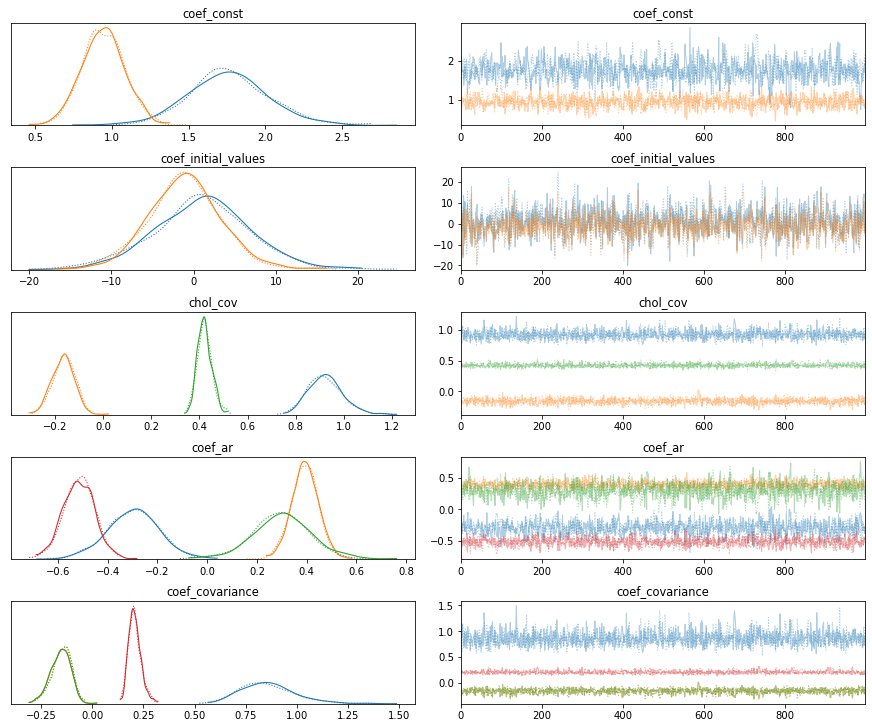

In [17]:
axs = az.plot_trace(ifd, compact=True)
fig = axs[0, 0].figure

# fig.tight_layout()
fig.savefig(img_path / "pp_var_trace.png");

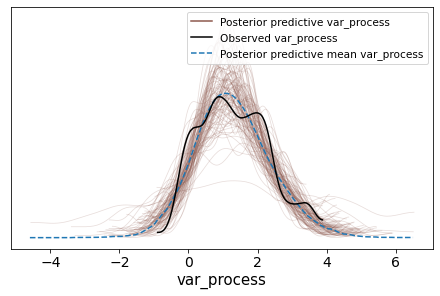

In [18]:
ax, = az.plot_ppc(ifd)
fig = ax.figure

# fig.tight_layout()
fig.savefig(img_path / "pp_var_ppc.png");

### Compare estimated coeffs with actual values

In [19]:
est_params = ifd.posterior.mean(dim=['chain', 'draw'])

In [20]:
_vars = list(set(vg.params.data_vars).intersection(est_params.data_vars))

In [21]:
comparison = xr.merge([
    vg.params.expand_dims(source=['actual'])[_vars],
    est_params.expand_dims(source=['estimated'])[_vars],
])
comparison

<xarray.Dataset>
Dimensions:              (endog: 2, lag_endog: 1, pre_vals: 1, source: 2, target: 2)
Coordinates:
  * source               (source) object 'actual' 'estimated'
  * lag_endog            (lag_endog) int64 1
  * endog                (endog) int64 0 1
  * pre_vals             (pre_vals) int64 -1
  * target               (target) int64 0 1
Data variables:
    coef_covariance      (source, target, endog) float64 0.8736 ... 0.2082
    coef_const           (source, target) float64 1.845 0.8657 1.763 0.9439
    coef_ar              (source, target, endog, lag_endog) float64 -0.3071 ... -0.5155
    coef_initial_values  (source, pre_vals, target) float64 2.134 ... -1.126

In [22]:
import textwrap

for k in list(comparison.data_vars):
    ck = comparison[k]
    
    print(f"{k}:")
    print(textwrap.indent(f"{ck.sel(source='actual').values}", ' ' * 4))
    print("    vs")
    print(textwrap.indent(f"{ck.sel(source='estimated').values}", ' ' * 4))
    print(" ")

coef_covariance:
    [[ 0.87357446 -0.16278076]
     [-0.16278076  0.24875897]]
    vs
    [[ 0.86034634 -0.15335224]
     [-0.15335224  0.2082159 ]]
 
coef_const:
    [1.84498536 0.86565078]
    vs
    [1.76313886 0.94389544]
 
coef_ar:
    [[[-0.3071447 ]
      [ 0.24891679]]

     [[ 0.40224754]
      [-0.45696649]]]
    vs
    [[[-0.29788682]
      [ 0.39307502]]

     [[ 0.29877447]
      [-0.51554693]]]
 
coef_initial_values:
    [[2.13401132 0.85730312]]
    vs
    [[ 1.05873869 -1.12622967]]
 


### Plot range from PPC

In [23]:
vppc = ifd.posterior_predictive
v_mean = vppc['var_process'].mean(dim=['chain', 'draw'])
_v_hdi = az.hdi(vppc, hdi_prob=0.95)
_v_hdi['hdi'] = ['lower', 'upper']
v_hdi = _v_hdi['var_process'].to_dataset(dim='hdi')
v_vals = v_hdi.combine_first(v_mean.to_dataset(name='mean'))

/opt/conda/envs/rs-model/lib/python3.8/site-packages/pandas/plotting/_matplotlib/style.py:60: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  [conv.to_rgba(c) for c in colors]


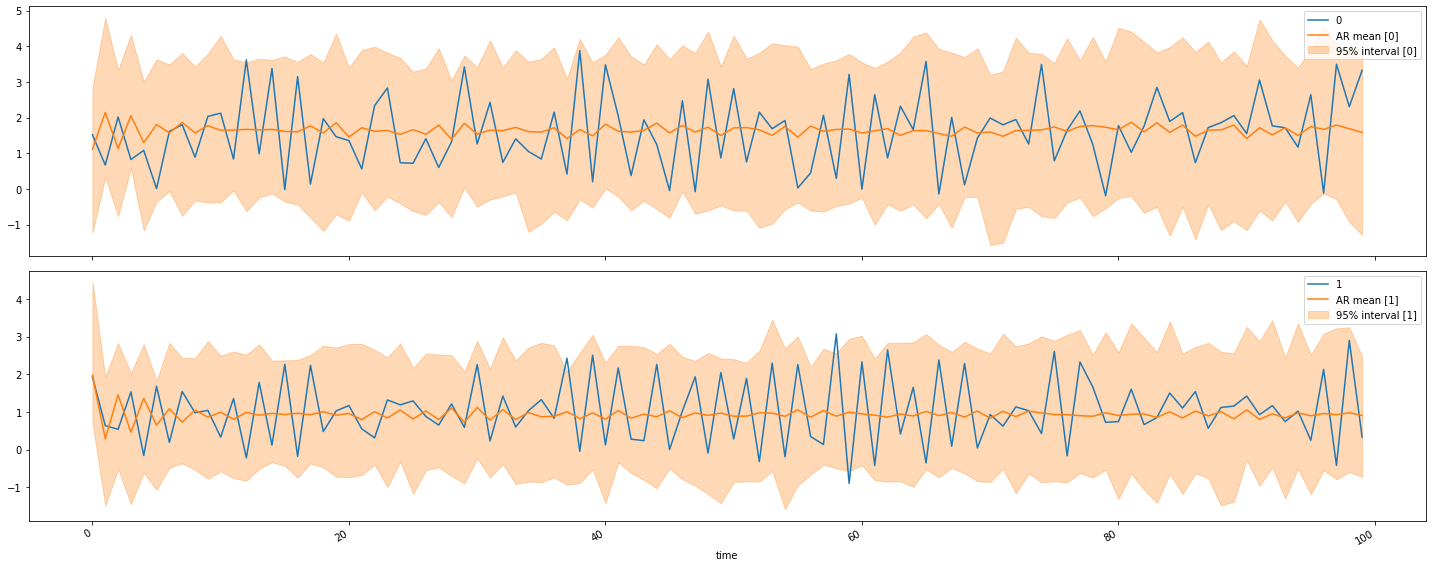

In [24]:
import matplotlib.pyplot as plt

axs = data['output'].to_series().unstack('target').plot(color='C0', figsize=(20, 8), subplots=True)
fig = axs[0].figure
for i, ax in enumerate(axs):
    hh = v_vals.isel(target=i)
    
    ax.plot(
        hh['time'], 
        hh['mean'].values, 
        color='C1', 
        label=f'AR mean [{i}]',
    )
    ax.fill_between(
        hh['time'], 
        hh['lower'].values, 
        hh['upper'].values, 
        color='C1', alpha=0.3, 
        label=f"95% interval [{i}]",
    )
    # v_mean.to_series().unstack('target').plot(color='C1', ax=axs, subplots=True)
    ax.legend()


fig.tight_layout()
fig.savefig(img_path / "pp_var_realization.png");